In [2]:
# Basic imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature generation 
import moten
import pandas
from scipy.io import loadmat
from sklearn import preprocessing

# Dimensionality reduction
from sklearn.decomposition import PCA

%matplotlib inline
%autosave 5

Autosaving every 5 seconds


In [3]:
#### Set data location

directory = os.path.join(os.path.expanduser('~'), 'Documents', 'Data')
video_range = range(5, 157)

print('Data location:', directory)


Data location: /Users/angira/Documents/Data


<h1>Motion energy</h1>

In [4]:
#### Load videos

videos = []
for v in video_range:
    video_string = ('tr%03d.mov' % v)
    video_file = os.path.join(directory, 'stimuli', 'segmented_stimuli', video_string)
    luminance_images = moten.io.video2luminance(video_file, size=(180, 320))
    videos.append(luminance_images)

print('Final video array shape:', np.shape(videos))

Final video array shape: (152,)


In [5]:
#### Get filter responses

# Generate pyramid object
nimages, vdim, hdim = np.shape(videos[0])
pyramid = moten.get_default_pyramid(vhsize=(vdim, hdim), fps=24)

# Compute filter responses for each video
moten_features = []
for video in videos:
    # Get filter responses for all frames
    video_response = pyramid.project_stimulus(video)
    
    # Average across frames
    avg_response = np.mean(video_response, axis=0)
    
    moten_features.append(avg_response)

print('Motion Energy features:', np.shape(moten_features))



Motion Energy features: (152, 2530)


(129, 2)


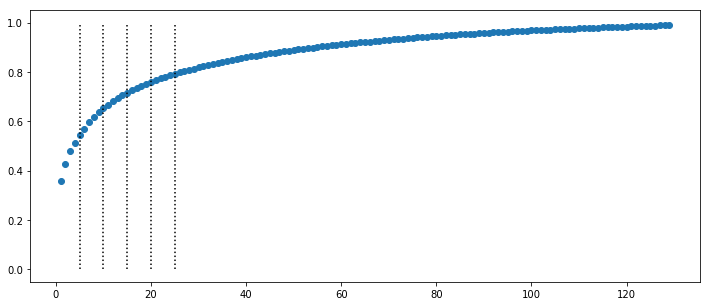

In [116]:
#### Plot elbow graph of motion energy PCs
moten_pc_performance = []
for pc_count in range(1,130):
    pca_model = PCA(n_components=pc_count)
    moten_pca = pca_model.fit_transform(moten_features)
    explained_variance = sum(pca_model.explained_variance_ratio_)
    moten_pc_performance.append((pc_count, explained_variance))

print(np.shape(moten_pc_performance))

x,y = zip(*moten_pc_performance)
plt.figure(figsize=(12,5))
plt.scatter(x, y)
plt.vlines(x=[5,10,15,20,25], ymin=0, ymax=1.0, linestyle=":")
plt.show()


In [9]:
#### Perform PCA on motion energy filter responses

motion_pca = PCA(n_components=9) # minimum number to ensure 99% variance explained
moten_pca = motion_pca.fit_transform(moten_features)

print('Reduced responses:', np.shape(moten_pca))
print('Explained variance:', sum(motion_pca.explained_variance_ratio_))


Reduced responses: (152, 9)
Explained variance: 0.6363955262619285


In [10]:
#### Save features to file

np.save(os.path.join(directory, 'features', 'moten_reduced9.npy'), moten_pca)
print('Saved responses')


Saved responses


<h1>AlexNet</h1>

In [5]:
##### Prepare features for AlexNet model

# Load features and format to be easily indexible
alexnet_reps = loadmat(os.path.join(directory, 'features', 'alexnet_representations.mat'))
alexnet_reps = alexnet_reps.get('representations')
alexnet_reps = np.swapaxes(alexnet_reps, 0, 1)

# Unpack representations from internal cells
alexnet_features = []
for i in range(len(alexnet_reps)):
    alexnet_features.append(alexnet_reps[i][0])

# Squeeze away extra axis
alexnet_features = np.squeeze(alexnet_features)

# Flatten 3D array 
alexnet_features= np.reshape(alexnet_features, (152, 9216))

print('AlexNet features:', np.shape(alexnet_features))

AlexNet features: (152, 9216)


In [6]:
#### Perform PCA on AlexNet features

alexnet_pca_model = PCA(n_components=20) # minimum number to ensure 99% variance explained
alexnet_pca = alexnet_pca_model.fit_transform(alexnet_features)

print('Reduced responses:', np.shape(alexnet_pca))
print('Explained variance:', sum(alexnet_pca_model.explained_variance_ratio_))

Reduced responses: (152, 20)
Explained variance: 0.730473536066711


In [8]:
#### Save features to file

np.save(os.path.join(directory, 'features', 'alexnet_reduced20.npy'), alexnet_pca)
print('Saved features')

Saved features


<h1>Social features</h1>

In [42]:
#### Load features

social_dframe = pandas.read_csv(os.path.join(directory, 'stimuli', 'feature_labels.csv'))
social_features = social_dframe.to_numpy(dtype=float)
social_names = social_dframe.keys().to_numpy(dtype=str)
                                             
print('Feature names:', social_names)
print(np.shape(social_features))


Feature names: ['Faces' 'Interaction' 'ToM' 'Valence' 'Arousal']
(152, 5)


In [43]:
#### Save raw social features to file
np.save(os.path.join(directory, 'features', 'social_raw.npy'), social_features)
print('Saved features')


Saved features


In [44]:
#### Normalize features

feature_scaler = preprocessing.StandardScaler()
feature_scaler.fit(social_features)
normalized_social_features = feature_scaler.transform(social_features)

print('Normalized features shape:', np.shape(normalized_social_features))

Normalized features shape: (152, 5)


In [5]:
#### Save normalized social features to file

np.save(os.path.join(directory, 'features', 'social_normalized.npy'), normalized_social_features)
print('Saved features')

Saved features


In [45]:
#### Load Richardson et al reverse correlation ToM features

rev_corr_dframe = pandas.read_csv(os.path.join(directory, 'stimuli', 'rev_corr_tom.csv'))
rev_corr_feature = rev_corr_dframe.to_numpy(dtype=float)
rev_corr_names = rev_corr_dframe.keys().to_numpy(dtype=str)
                                             
print('Feature names:', rev_corr_names)
print(np.shape(rev_corr_feature))

Feature names: ['Rev Corr ToM']
(152, 1)


In [26]:
np.save(os.path.join(directory, 'features', 'rev_corr_tom.npy'), rev_corr_feature)
print('Saved feature')

Saved feature


In [46]:
#### Generate social feature set with rev corr feature

# Delete original ToM feature
social_features_rev_corr = np.delete(np.copy(social_features), obj=2, axis=1)
print(np.shape(social_features))
print(np.shape(social_features_rev_corr))

# Append new rev corr feature
social_features_rev_corr = np.concatenate((social_features_rev_corr, rev_corr_feature), axis=1)
print(np.shape(social_features_rev_corr))

(152, 5)
(152, 4)
(152, 5)


In [47]:
#### Normalize rev corr features

feature_scaler = preprocessing.StandardScaler()
feature_scaler.fit(social_features_rev_corr)
normalized_social_features_rev_corr = feature_scaler.transform(social_features_rev_corr)

print('Normalized features shape:', np.shape(normalized_social_features))

Normalized features shape: (152, 5)


In [80]:
np.save(os.path.join(directory, 'features', 'social_features_rev_corr_tom.npy'), normalized_social_features_rev_corr)
print('Saved feature')

Saved feature


<h1>Feature analysis</h1>

In [48]:
#### Helper functions

def get_euclidean_distance(feature):
    """
        Compute the Euclidean distances within a feature
    """
    distance_matrix = []

    for i in range(len(feature)):
        column = []
        for j in range(len(feature)):
            dist = np.linalg.norm(feature[i]-feature[j])
            column.append(dist)
        distance_matrix.append(column)
    return distance_matrix

def correlate_matrices(matrix1, matrix2):
    """
        Return a correlation matrix and a single correlation coefficient for the two sets.
    """
    ## Extract matrix
    rdm = np.corrcoef(matrix1, matrix2)
    # Get only the part of the matrix where the two features are correlated -- the bottom left quarter
    rdm_trimmed = rdm[len(matrix1):len(rdm),0:len(matrix1)]
    
    ## Extract coefficient
    matrix1_flat = flat_tril_matrix(matrix1)
    matrix2_flat = flat_tril_matrix(matrix2)
    corr_coef = np.corrcoef(matrix1_flat, matrix2_flat)[0][1]
    
    return rdm_trimmed, corr_coef

def flat_tril_matrix(matrix):
    """
        Get the flattened lower triangular of a matrix
    """
    # Put NaNs in the upper triangular
    matrix = np.tril(matrix) # Guarantees an NP array
    matrix[np.triu_indices(n=np.shape(matrix)[0], k=-1)] = np.nan
    # Convert matrix to 1 dimension
    matrix_flat = np.ravel(matrix)
    # Remove NaNs so only flat lower triangular remains
    matrix_flat = matrix_flat[~np.isnan(matrix_flat)]
    return matrix_flat


In [49]:
#### Correlate features for timepoints 8 & 9, indexes 3 & 4 (birds flying across screen) 

print('Non-reduced AlexNet correlation:')
print(np.corrcoef(alexnet_features[3], alexnet_features[4]))

print('Reduced AlexNet correlation:')
print(np.corrcoef(alexnet_pca[3], alexnet_pca[4]))

print('Non-reduced moten correlation:')
print(np.corrcoef(moten_features[3], moten_features[4]))

print('Reduced moten correlation:')
print(np.corrcoef(moten_pca[3], moten_pca[4]))


Non-reduced AlexNet correlation:
[[1.         0.99992168]
 [0.99992168 1.        ]]
Reduced AlexNet correlation:
[[1.         0.30439343]
 [0.30439343 1.        ]]
Non-reduced moten correlation:
[[1.         0.89320589]
 [0.89320589 1.        ]]
Reduced moten correlation:
[[1.         0.57739937]
 [0.57739937 1.        ]]


In [50]:
#### Correlations for timepoints 127 & 128, indexes 122 & 123(angry Gus)

print('Non-reduced AlexNet correlation:')
print(np.corrcoef(alexnet_features[122], alexnet_features[123]))

print('Reduced AlexNet correlation:')
print(np.corrcoef(alexnet_pca[122], alexnet_pca[123]))

print('Non-reduced moten correlation:')
print(np.corrcoef(moten_features[122], moten_features[123]))

print('Reduced moten correlation:')
print(np.corrcoef(moten_pca[122], moten_pca[123]))


Non-reduced AlexNet correlation:
[[1.         0.99999066]
 [0.99999066 1.        ]]
Reduced AlexNet correlation:
[[1.         0.83073673]
 [0.83073673 1.        ]]
Non-reduced moten correlation:
[[1.         0.93571594]
 [0.93571594 1.        ]]
Reduced moten correlation:
[[1.         0.63349838]
 [0.63349838 1.        ]]


In [51]:
#### Correlate features for timepoints 8 & 14, indexes 3 & 9 (birds flying across screen and bird delivering puppy) 

print('Non-reduced AlexNet correlation:')
print(np.corrcoef(alexnet_features[3], alexnet_features[9]))

print('Reduced AlexNet correlation:')
print(np.corrcoef(alexnet_pca[3], alexnet_pca[9]))

print('Non-reduced moten correlation:')
print(np.corrcoef(moten_features[3], moten_features[9]))

print('Reduced moten correlation:')
print(np.corrcoef(moten_pca[3], moten_pca[9]))


Non-reduced AlexNet correlation:
[[1.        0.9998837]
 [0.9998837 1.       ]]
Reduced AlexNet correlation:
[[1.         0.28398431]
 [0.28398431 1.        ]]
Non-reduced moten correlation:
[[1.         0.80714217]
 [0.80714217 1.        ]]
Reduced moten correlation:
[[1.         0.27618357]
 [0.27618357 1.        ]]


In [53]:
#### Get RDMs for AlexNet and MotEn

alexnet_rsm = np.corrcoef(alexnet_features)
alexnet_rdm = 1 - alexnet_rsm
moten_rsm = np.corrcoef(moten_features)
moten_rdm = 1 - moten_rsm

###Compare perceptual models
alexnet_moten_rdm, alexnet_moten_corr = correlate_matrices(alexnet_rdm, moten_rdm)

### Get RDMS for PCA reduced versions
alexnet_pca_rsm = np.corrcoef(alexnet_pca)
alexnet_pca_rdm = 1 - alexnet_pca_rsm
moten_pca_rsm = np.corrcoef(moten_pca)
moten_pca_rdm = 1 - moten_pca_rsm

## Compare perceptual models
alexnet_moten_pca_rdm, alexnet_moten_pca_corr = correlate_matrices(alexnet_pca_rdm, moten_pca_rdm)


AlexNet - MotEn: 0.1628547148020862
AlexNet - MotEn PCA: 0.22106648833914458


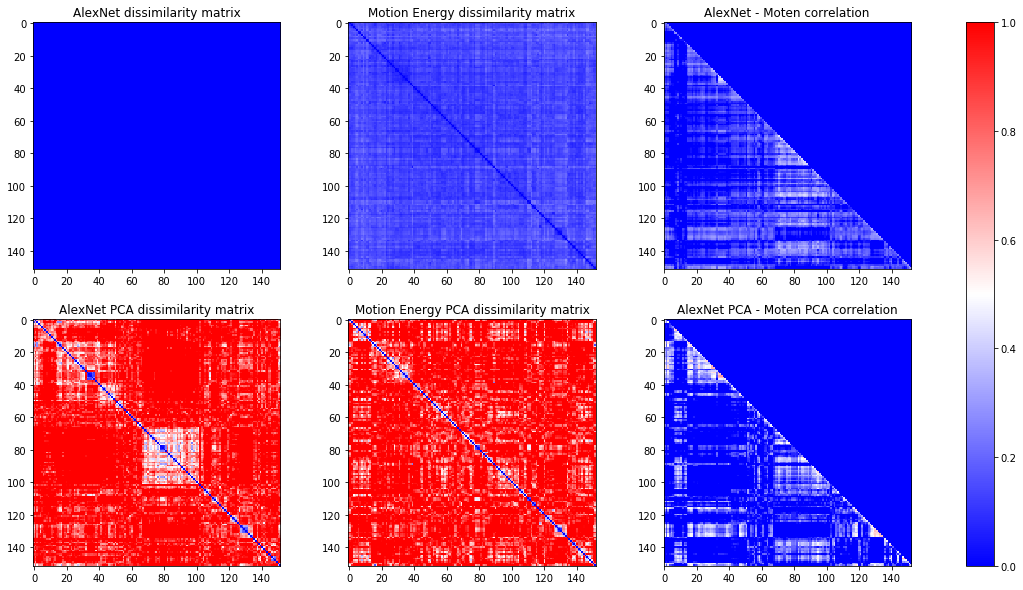

In [54]:
#### Plot AlexNet and Motion Energy dissimilarities
# here, light colors indicate low correlation, darker indicates higher correlation

print('AlexNet - MotEn:', alexnet_moten_corr)
print('AlexNet - MotEn PCA:', alexnet_moten_pca_corr)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))

im1 = axes[0][0].imshow(alexnet_rdm, vmin=0, vmax=1, cmap='bwr')
axes[0][0].title.set_text('AlexNet dissimilarity matrix')

im2 = axes[0][1].imshow(moten_rdm, vmin=0, vmax=1, cmap='bwr')
axes[0][1].title.set_text('Motion Energy dissimilarity matrix')

im3 = axes[0][2].imshow(np.tril(alexnet_moten_rdm), vmin=0, vmax=1, cmap='bwr')
axes[0][2].title.set_text('AlexNet - Moten correlation')

im4 = axes[1][0].imshow(alexnet_pca_rdm, vmin=0, vmax=1, cmap='bwr')
axes[1][0].title.set_text('AlexNet PCA dissimilarity matrix')

im5 = axes[1][1].imshow(moten_pca_rdm, vmin=0, vmax=1, cmap='bwr')
axes[1][1].title.set_text('Motion Energy PCA dissimilarity matrix')

im6 = axes[1][2].imshow(np.tril(alexnet_moten_pca_rdm), vmin=0, vmax=1, cmap='bwr')
axes[1][2].title.set_text('AlexNet PCA - Moten PCA correlation')

colorbar = fig.colorbar(im2, ax=axes.ravel().tolist())

In [55]:
#### Isolate social features - non normalized versions

faces = social_features[:,0]
interaction = social_features[:,1]
labeled_tom = social_features[:,2]
valence = social_features[:,3]
arousal = social_features[:,4]

#### Calculate distance matrices for social features, then get lower triangular

interaction_distance = get_euclidean_distance(interaction)
labeled_tom_distance = get_euclidean_distance(labeled_tom)
rev_corr_tom_distance = get_euclidean_distance(rev_corr_feature)
faces_distance = get_euclidean_distance(faces)
valence_distance = get_euclidean_distance(valence)
arousal_distance = get_euclidean_distance(arousal)

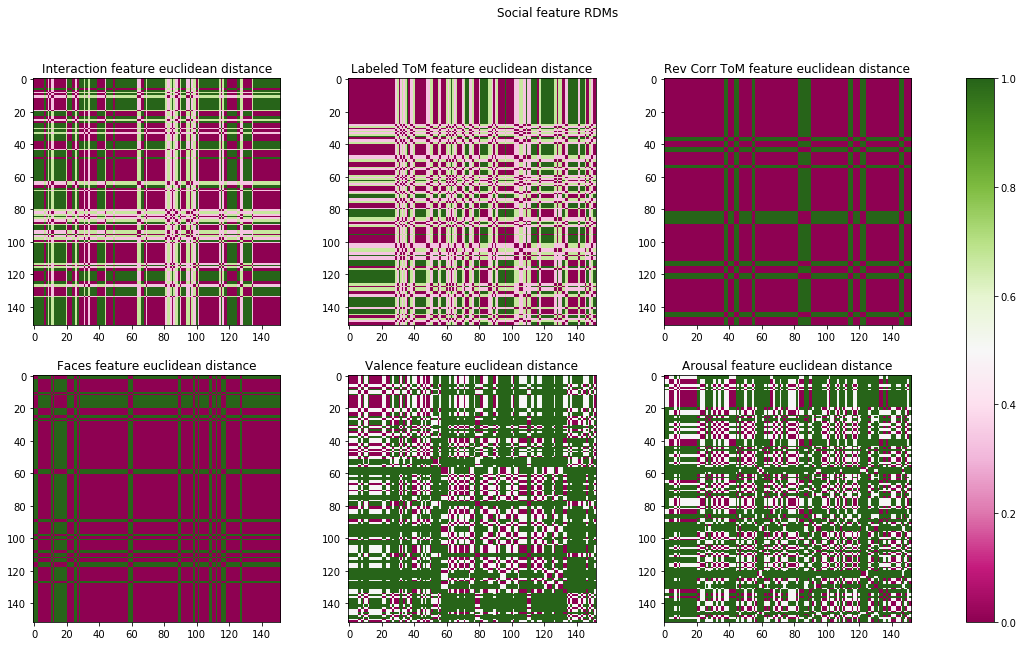

In [56]:
### Plot social feature distance matrices

# Note, for faces, interaction, and tom white indicate disagreement
# For valence and arousal, white indicates neutral, while dark indicates extremes

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
fig.suptitle('Social feature RDMs')

im1 = axes[0][0].imshow(interaction_distance, vmin=0, vmax=1, cmap='PiYG')
axes[0][0].title.set_text('Interaction feature euclidean distance')
im2 = axes[0][1].imshow(labeled_tom_distance, vmin=0, vmax=1, cmap='PiYG')
axes[0][1].title.set_text('Labeled ToM feature euclidean distance')
im3 = axes[0][2].imshow(rev_corr_tom_distance, vmin=0, vmax=1, cmap='PiYG')
axes[0][2].title.set_text('Rev Corr ToM feature euclidean distance')
im4 = axes[1][0].imshow(faces_distance, vmin=0, vmax=1, cmap='PiYG')
axes[1][0].title.set_text('Faces feature euclidean distance')
im5 = axes[1][1].imshow(valence_distance, vmin=0, vmax=1, cmap='PiYG')
axes[1][1].title.set_text('Valence feature euclidean distance')
im6 = axes[1][2].imshow(arousal_distance, vmin=0, vmax=1, cmap='PiYG')
axes[1][2].title.set_text('Arousal feature euclidean distance')

colorbar = fig.colorbar(im3, ax=axes.ravel().tolist())

Interaction - AlexNet:  0.04663406195947534
Interaction - MotEn: 0.11800938973834606
Interaction - AlexNet PCA:  0.028731997214245967
Interaction - MotEn PCA: 0.049226453089069346


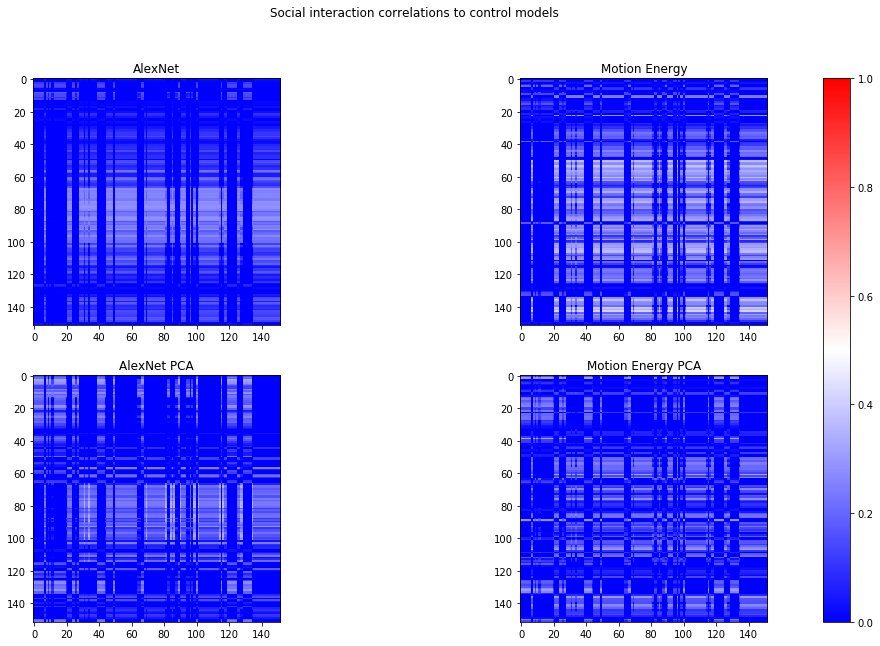

In [57]:
#### Social interaction

interaction_alexnet_rdm, interaction_alexnet_corr = correlate_matrices(interaction_distance, alexnet_rdm)
interaction_moten_rdm, interaction_moten_corr = correlate_matrices(interaction_distance, moten_rdm,)
interaction_alexnet_pca_rdm, interaction_alexnet_pca_corr = correlate_matrices(interaction_distance, alexnet_pca_rdm)
interaction_moten_pca_rdm, interaction_moten_pca_corr = correlate_matrices(interaction_distance, moten_pca_rdm)
print('Interaction - AlexNet: ', interaction_alexnet_corr)
print('Interaction - MotEn:', interaction_moten_corr)
print('Interaction - AlexNet PCA: ', interaction_alexnet_pca_corr)
print('Interaction - MotEn PCA:', interaction_moten_pca_corr)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
fig.suptitle('Social interaction correlations to control models')

im1 = axes[0][0].imshow(interaction_alexnet_rdm, vmin=0, vmax=1, cmap='bwr')
axes[0][0].title.set_text('AlexNet')
im2 = axes[0][1].imshow(interaction_moten_rdm, vmin=0, vmax=1, cmap='bwr')
axes[0][1].title.set_text('Motion Energy')

im1 = axes[1][0].imshow(interaction_alexnet_pca_rdm, vmin=0, vmax=1, cmap='bwr')
axes[1][0].title.set_text('AlexNet PCA')
im2 = axes[1][1].imshow(interaction_moten_pca_rdm, vmin=0, vmax=1, cmap='bwr')
axes[1][1].title.set_text('Motion Energy PCA')
colorbar = fig.colorbar(im2, ax=axes.ravel().tolist())

Faces - AlexNet:  0.003031511897532847
Faces - MotEn: 0.11329771762834999
Faces - AlexNet PCA:  0.01795830212641605
Faces - MotEn PCA: 0.06218814140391547


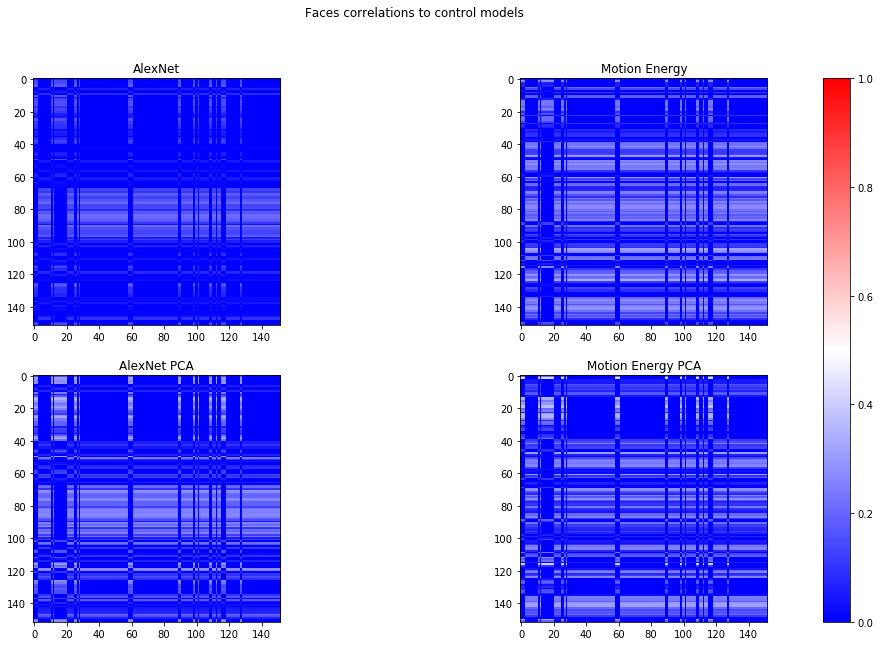

In [58]:
#### Faces

faces_alexnet_rdm, faces_alexnet_corr = correlate_matrices(faces_distance, alexnet_rdm)
faces_moten_rdm, faces_moten_corr = correlate_matrices(faces_distance, moten_rdm,)
faces_alexnet_pca_rdm, faces_alexnet_pca_corr = correlate_matrices(faces_distance, alexnet_pca_rdm)
faces_moten_pca_rdm, faces_moten_pca_corr = correlate_matrices(faces_distance, moten_pca_rdm)
print('Faces - AlexNet: ', faces_alexnet_corr)
print('Faces - MotEn:', faces_moten_corr)
print('Faces - AlexNet PCA: ', faces_alexnet_pca_corr)
print('Faces - MotEn PCA:', faces_moten_pca_corr)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
fig.suptitle('Faces correlations to control models')

im1 = axes[0][0].imshow(faces_alexnet_rdm, vmin=0, vmax=1, cmap='bwr')
axes[0][0].title.set_text('AlexNet')
im2 = axes[0][1].imshow(faces_moten_rdm, vmin=0, vmax=1, cmap='bwr')
axes[0][1].title.set_text('Motion Energy')

im1 = axes[1][0].imshow(faces_alexnet_pca_rdm, vmin=0, vmax=1, cmap='bwr')
axes[1][0].title.set_text('AlexNet PCA')
im2 = axes[1][1].imshow(faces_moten_pca_rdm, vmin=0, vmax=1, cmap='bwr')
axes[1][1].title.set_text('Motion Energy PCA')
colorbar = fig.colorbar(im2, ax=axes.ravel().tolist())

Rev Corr ToM - AlexNet:  0.004393238145396839
Rev Corr ToM - MotEn: 0.0020553166193931997
Rev Corr ToM - AlexNet PCA:  0.017870956653371135
Rev Corr ToM - MotEn PCA: -0.01208076805850662


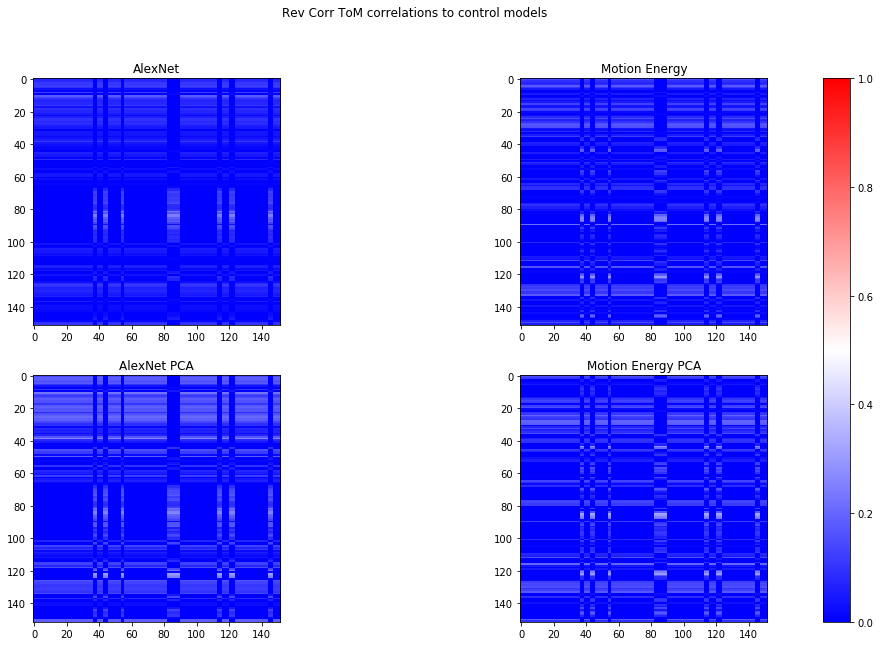

In [59]:
#### Rev Corr ToM

rev_corr_tom_alexnet_rdm, rev_corr_tom_alexnet_corr = correlate_matrices(rev_corr_tom_distance, alexnet_rdm)
rev_corr_tom_moten_rdm, rev_corr_tom_moten_corr = correlate_matrices(rev_corr_tom_distance, moten_rdm,)
rev_corr_tom_alexnet_pca_rdm, rev_corr_tom_alexnet_pca_corr = correlate_matrices(rev_corr_tom_distance, alexnet_pca_rdm)
rev_corr_tom_moten_pca_rdm, rev_corr_tom_moten_pca_corr = correlate_matrices(rev_corr_tom_distance, moten_pca_rdm)
print('Rev Corr ToM - AlexNet: ', rev_corr_tom_alexnet_corr)
print('Rev Corr ToM - MotEn:', rev_corr_tom_moten_corr)
print('Rev Corr ToM - AlexNet PCA: ', rev_corr_tom_alexnet_pca_corr)
print('Rev Corr ToM - MotEn PCA:', rev_corr_tom_moten_pca_corr)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
fig.suptitle('Rev Corr ToM correlations to control models')

im1 = axes[0][0].imshow(rev_corr_tom_alexnet_rdm, vmin=0, vmax=1, cmap='bwr')
axes[0][0].title.set_text('AlexNet')
im2 = axes[0][1].imshow(rev_corr_tom_moten_rdm, vmin=0, vmax=1, cmap='bwr')
axes[0][1].title.set_text('Motion Energy')

im1 = axes[1][0].imshow(rev_corr_tom_alexnet_pca_rdm, vmin=0, vmax=1, cmap='bwr')
axes[1][0].title.set_text('AlexNet PCA')
im2 = axes[1][1].imshow(rev_corr_tom_moten_pca_rdm, vmin=0, vmax=1, cmap='bwr')
axes[1][1].title.set_text('Motion Energy PCA')
colorbar = fig.colorbar(im2, ax=axes.ravel().tolist())

Labeled ToM - AlexNet:  -0.018604103111167305
Labeled ToM - MotEn: 0.03385613711433926
Labeled ToM - AlexNet PCA:  0.04437943283989026
Labeled ToM - MotEn PCA: 0.03732618241407826


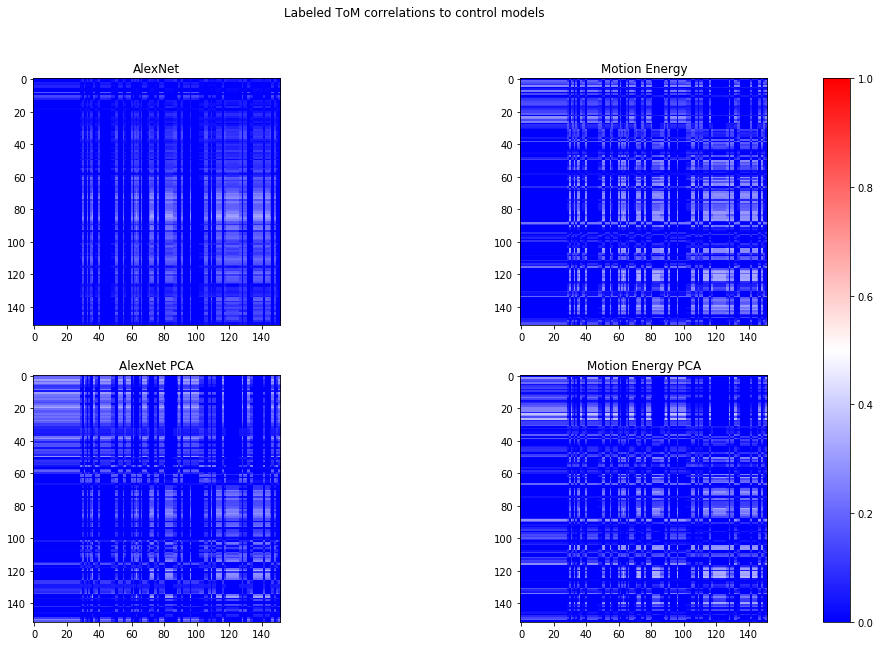

In [60]:
#### Labeled ToM

labeled_tom_alexnet_rdm, labeled_tom_alexnet_corr = correlate_matrices(labeled_tom_distance, alexnet_rdm)
labeled_tom_moten_rdm, labeled_tom_moten_corr = correlate_matrices(labeled_tom_distance, moten_rdm,)
labeled_tom_alexnet_pca_rdm, labeled_tom_alexnet_pca_corr = correlate_matrices(labeled_tom_distance, alexnet_pca_rdm)
labeled_tom_moten_pca_rdm, labeled_tom_moten_pca_corr = correlate_matrices(labeled_tom_distance, moten_pca_rdm)
print('Labeled ToM - AlexNet: ', labeled_tom_alexnet_corr)
print('Labeled ToM - MotEn:', labeled_tom_moten_corr)
print('Labeled ToM - AlexNet PCA: ', labeled_tom_alexnet_pca_corr)
print('Labeled ToM - MotEn PCA:', labeled_tom_moten_pca_corr)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
fig.suptitle('Labeled ToM correlations to control models')

im1 = axes[0][0].imshow(labeled_tom_alexnet_rdm, vmin=0, vmax=1, cmap='bwr')
axes[0][0].title.set_text('AlexNet')
im2 = axes[0][1].imshow(labeled_tom_moten_rdm, vmin=0, vmax=1, cmap='bwr')
axes[0][1].title.set_text('Motion Energy')

im1 = axes[1][0].imshow(labeled_tom_alexnet_pca_rdm, vmin=0, vmax=1, cmap='bwr')
axes[1][0].title.set_text('AlexNet PCA')
im2 = axes[1][1].imshow(labeled_tom_moten_pca_rdm, vmin=0, vmax=1, cmap='bwr')
axes[1][1].title.set_text('Motion Energy PCA')
colorbar = fig.colorbar(im2, ax=axes.ravel().tolist())

Valence - AlexNet:  -0.011556359224073007
Valence - MotEn: 0.08385984667054408
Valence - AlexNet PCA:  0.055201359548359356
Valence - MotEn PCA: 0.03263719108611219


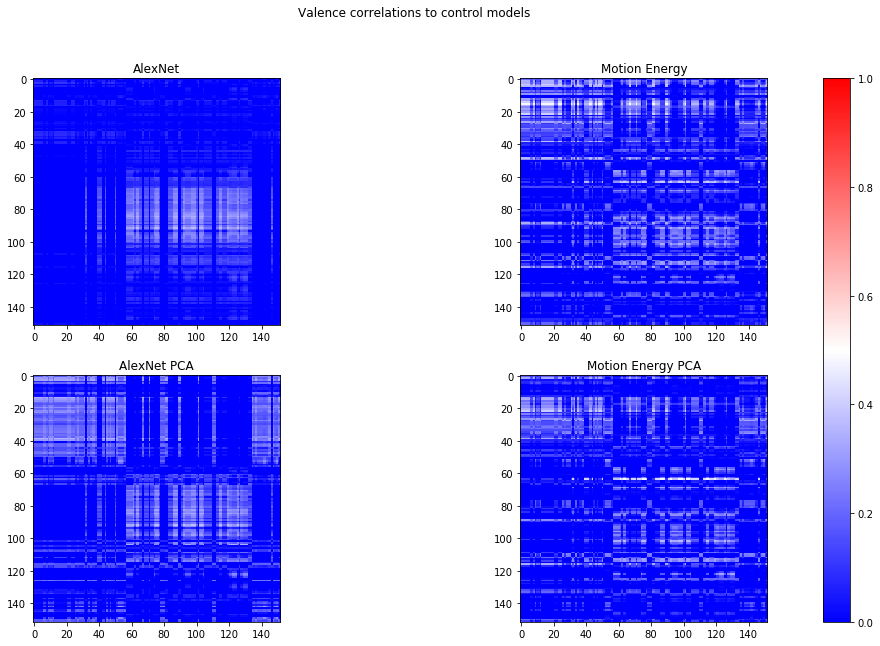

In [61]:
#### Valence

valence_alexnet_rdm, valence_alexnet_corr = correlate_matrices(valence_distance, alexnet_rdm)
valence_moten_rdm, valence_moten_corr = correlate_matrices(valence_distance, moten_rdm,)
valence_alexnet_pca_rdm, valence_alexnet_pca_corr = correlate_matrices(valence_distance, alexnet_pca_rdm)
valence_moten_pca_rdm, valence_moten_pca_corr = correlate_matrices(valence_distance, moten_pca_rdm)
print('Valence - AlexNet: ', valence_alexnet_corr)
print('Valence - MotEn:', valence_moten_corr)
print('Valence - AlexNet PCA: ', valence_alexnet_pca_corr)
print('Valence - MotEn PCA:', valence_moten_pca_corr)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
fig.suptitle('Valence correlations to control models')

im1 = axes[0][0].imshow(valence_alexnet_rdm, vmin=0, vmax=1, cmap='bwr')
axes[0][0].title.set_text('AlexNet')
im2 = axes[0][1].imshow(valence_moten_rdm, vmin=0, vmax=1, cmap='bwr')
axes[0][1].title.set_text('Motion Energy')

im1 = axes[1][0].imshow(valence_alexnet_pca_rdm, vmin=0, vmax=1, cmap='bwr')
axes[1][0].title.set_text('AlexNet PCA')
im2 = axes[1][1].imshow(valence_moten_pca_rdm, vmin=0, vmax=1, cmap='bwr')
axes[1][1].title.set_text('Motion Energy PCA')
colorbar = fig.colorbar(im2, ax=axes.ravel().tolist())

Arousal - AlexNet:  -0.009968824734056242
Arousal - MotEn: 0.12400900986178255
Arousal - AlexNet PCA:  0.013972445569387185
Arousal - MotEn PCA: 0.03329484415677251


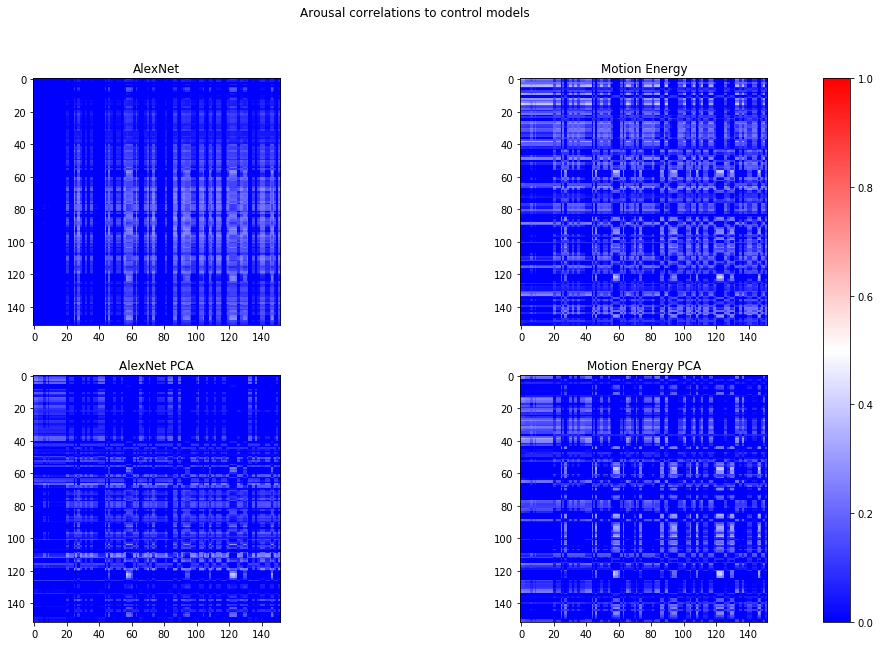

In [62]:
#### Arousal

arousal_alexnet_rdm, arousal_alexnet_corr = correlate_matrices(arousal_distance, alexnet_rdm)
arousal_moten_rdm, arousal_moten_corr = correlate_matrices(arousal_distance, moten_rdm,)
arousal_alexnet_pca_rdm, arousal_alexnet_pca_corr = correlate_matrices(arousal_distance, alexnet_pca_rdm)
arousal_moten_pca_rdm, arousal_moten_pca_corr = correlate_matrices(arousal_distance, moten_pca_rdm)
print('Arousal - AlexNet: ', arousal_alexnet_corr)
print('Arousal - MotEn:', arousal_moten_corr)
print('Arousal - AlexNet PCA: ', arousal_alexnet_pca_corr)
print('Arousal - MotEn PCA:', arousal_moten_pca_corr)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
fig.suptitle('Arousal correlations to control models')

im1 = axes[0][0].imshow(arousal_alexnet_rdm, vmin=0, vmax=1, cmap='bwr')
axes[0][0].title.set_text('AlexNet')
im2 = axes[0][1].imshow(arousal_moten_rdm, vmin=0, vmax=1, cmap='bwr')
axes[0][1].title.set_text('Motion Energy')

im1 = axes[1][0].imshow(arousal_alexnet_pca_rdm, vmin=0, vmax=1, cmap='bwr')
axes[1][0].title.set_text('AlexNet PCA')
im2 = axes[1][1].imshow(arousal_moten_pca_rdm, vmin=0, vmax=1, cmap='bwr')
axes[1][1].title.set_text('Motion Energy PCA')
colorbar = fig.colorbar(im2, ax=axes.ravel().tolist())

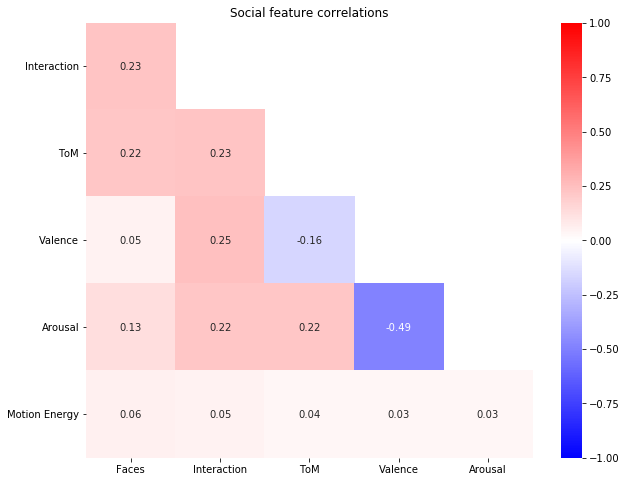

In [87]:
#### Plot correlations of social fetures with moten

social_corr = social_dframe.corr()
moten_corr = [faces_moten_pca_corr, 
              interaction_moten_pca_corr, 
              labeled_tom_moten_pca_corr, 
              valence_moten_pca_corr, 
              arousal_moten_pca_corr]
social_corr['Motion Energy'] = moten_corr
social_corr.loc[len(social_corr.index)] = [faces_moten_pca_corr, 
              interaction_moten_pca_corr, 
              labeled_tom_moten_pca_corr, 
              valence_moten_pca_corr, 
              arousal_moten_pca_corr, 1]
social_corr.index = ['Faces', 'Interaction', 'ToM', 'Valence', 'Arousal', 'Motion Energy']

fig, ax = plt.subplots(figsize=(10, 8))

# mask
mask = np.triu(np.ones_like(social_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
masked_corr = social_corr.iloc[1:,:-1].copy()

sns.heatmap(masked_corr, mask=mask, annot=True, fmt=".2f", cmap='bwr', vmin=-1, vmax=1)

# yticks
plt.yticks(rotation=0)
plt.title('Social feature correlations')
plt.show()

In [138]:
def normalize_pc(pc):
    norm = np.linalg.norm(pc)
    normalized_pc = pc / norm
    return normalized_pc

Comparisons with faces


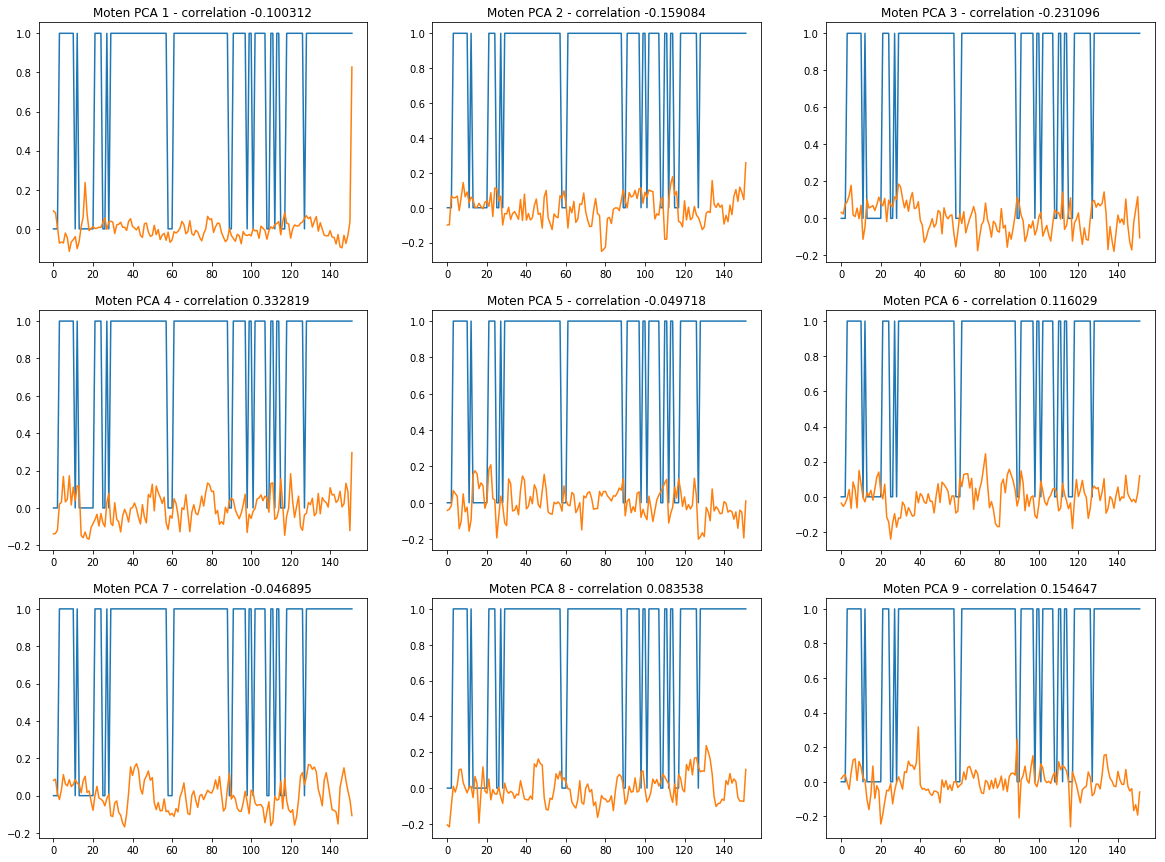

In [155]:
#### Compare moten PCs to social features

# Set social feature to social interaction
social_feature = social_features[:,0]
print('Comparisons with faces')

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,15))
ax[0][0].plot(social_feature)
ax[0][0].plot(normalize_pc(moten_pca[:,0]))
ax[0][0].title.set_text(
    'Moten PCA 1 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,0]))[0][1])

ax[0][1].plot(social_feature)
ax[0][1].plot(normalize_pc(moten_pca[:,1]))
ax[0][1].title.set_text(
    'Moten PCA 2 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,1]))[0][1])

ax[0][2].plot(social_feature)
ax[0][2].plot(normalize_pc(moten_pca[:,2]))
ax[0][2].title.set_text(
    'Moten PCA 3 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,2]))[0][1])

ax[1][0].plot(social_feature)
ax[1][0].plot(normalize_pc(moten_pca[:,3]))
ax[1][0].title.set_text(
    'Moten PCA 4 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,3]))[0][1])

ax[1][1].plot(social_feature)
ax[1][1].plot(normalize_pc(moten_pca[:,4]))
ax[1][1].title.set_text(
    'Moten PCA 5 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,4]))[0][1])

ax[1][2].plot(social_feature)
ax[1][2].plot(normalize_pc(moten_pca[:,5]))
ax[1][2].title.set_text(
    'Moten PCA 6 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,5]))[0][1])

ax[2][0].plot(social_feature)
ax[2][0].plot(normalize_pc(moten_pca[:,6]))
ax[2][0].title.set_text(
    'Moten PCA 7 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,6]))[0][1])

ax[2][1].plot(social_feature)
ax[2][1].plot(normalize_pc(moten_pca[:,7]))
ax[2][1].title.set_text(
    'Moten PCA 8 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,7]))[0][1])

ax[2][2].plot(social_feature)
ax[2][2].plot(normalize_pc(moten_pca[:,8]))
ax[2][2].title.set_text(
    'Moten PCA 9 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,8]))[0][1])

Comparisons with social interaction


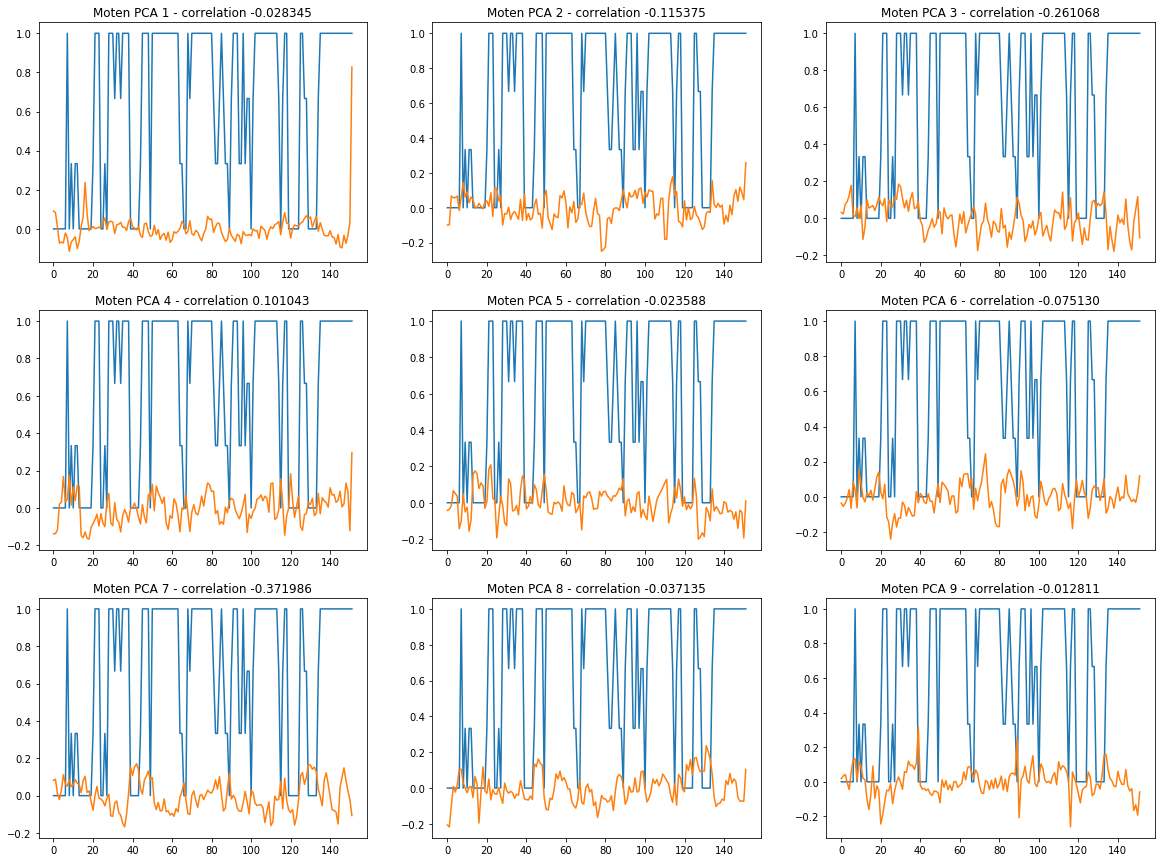

In [154]:
#### Compare moten PCs to social features

# Set social feature to social interaction
social_feature = social_features[:,1]
print('Comparisons with social interaction')

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,15))
ax[0][0].plot(social_feature)
ax[0][0].plot(normalize_pc(moten_pca[:,0]))
ax[0][0].title.set_text(
    'Moten PCA 1 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,0]))[0][1])

ax[0][1].plot(social_feature)
ax[0][1].plot(normalize_pc(moten_pca[:,1]))
ax[0][1].title.set_text(
    'Moten PCA 2 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,1]))[0][1])

ax[0][2].plot(social_feature)
ax[0][2].plot(normalize_pc(moten_pca[:,2]))
ax[0][2].title.set_text(
    'Moten PCA 3 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,2]))[0][1])

ax[1][0].plot(social_feature)
ax[1][0].plot(normalize_pc(moten_pca[:,3]))
ax[1][0].title.set_text(
    'Moten PCA 4 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,3]))[0][1])

ax[1][1].plot(social_feature)
ax[1][1].plot(normalize_pc(moten_pca[:,4]))
ax[1][1].title.set_text(
    'Moten PCA 5 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,4]))[0][1])

ax[1][2].plot(social_feature)
ax[1][2].plot(normalize_pc(moten_pca[:,5]))
ax[1][2].title.set_text(
    'Moten PCA 6 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,5]))[0][1])

ax[2][0].plot(social_feature)
ax[2][0].plot(normalize_pc(moten_pca[:,6]))
ax[2][0].title.set_text(
    'Moten PCA 7 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,6]))[0][1])

ax[2][1].plot(social_feature)
ax[2][1].plot(normalize_pc(moten_pca[:,7]))
ax[2][1].title.set_text(
    'Moten PCA 8 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,7]))[0][1])

ax[2][2].plot(social_feature)
ax[2][2].plot(normalize_pc(moten_pca[:,8]))
ax[2][2].title.set_text(
    'Moten PCA 9 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,8]))[0][1])



Comparisons with ToM


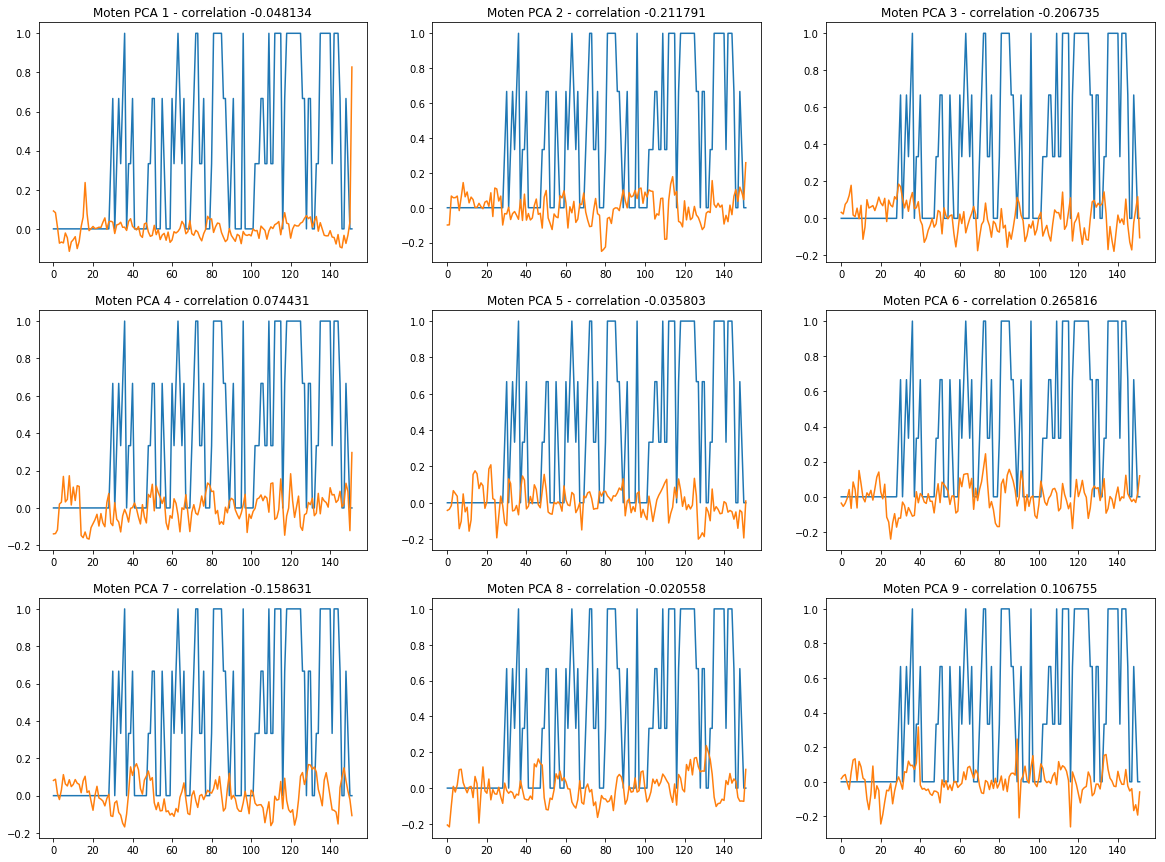

In [156]:
#### Compare moten PCs to social features

# Set social feature to social interaction
social_feature = social_features[:,2]
print('Comparisons with ToM')

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,15))
ax[0][0].plot(social_feature)
ax[0][0].plot(normalize_pc(moten_pca[:,0]))
ax[0][0].title.set_text(
    'Moten PCA 1 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,0]))[0][1])

ax[0][1].plot(social_feature)
ax[0][1].plot(normalize_pc(moten_pca[:,1]))
ax[0][1].title.set_text(
    'Moten PCA 2 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,1]))[0][1])

ax[0][2].plot(social_feature)
ax[0][2].plot(normalize_pc(moten_pca[:,2]))
ax[0][2].title.set_text(
    'Moten PCA 3 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,2]))[0][1])

ax[1][0].plot(social_feature)
ax[1][0].plot(normalize_pc(moten_pca[:,3]))
ax[1][0].title.set_text(
    'Moten PCA 4 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,3]))[0][1])

ax[1][1].plot(social_feature)
ax[1][1].plot(normalize_pc(moten_pca[:,4]))
ax[1][1].title.set_text(
    'Moten PCA 5 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,4]))[0][1])

ax[1][2].plot(social_feature)
ax[1][2].plot(normalize_pc(moten_pca[:,5]))
ax[1][2].title.set_text(
    'Moten PCA 6 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,5]))[0][1])

ax[2][0].plot(social_feature)
ax[2][0].plot(normalize_pc(moten_pca[:,6]))
ax[2][0].title.set_text(
    'Moten PCA 7 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,6]))[0][1])

ax[2][1].plot(social_feature)
ax[2][1].plot(normalize_pc(moten_pca[:,7]))
ax[2][1].title.set_text(
    'Moten PCA 8 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,7]))[0][1])

ax[2][2].plot(social_feature)
ax[2][2].plot(normalize_pc(moten_pca[:,8]))
ax[2][2].title.set_text(
    'Moten PCA 9 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,8]))[0][1])

Comparisons with valence


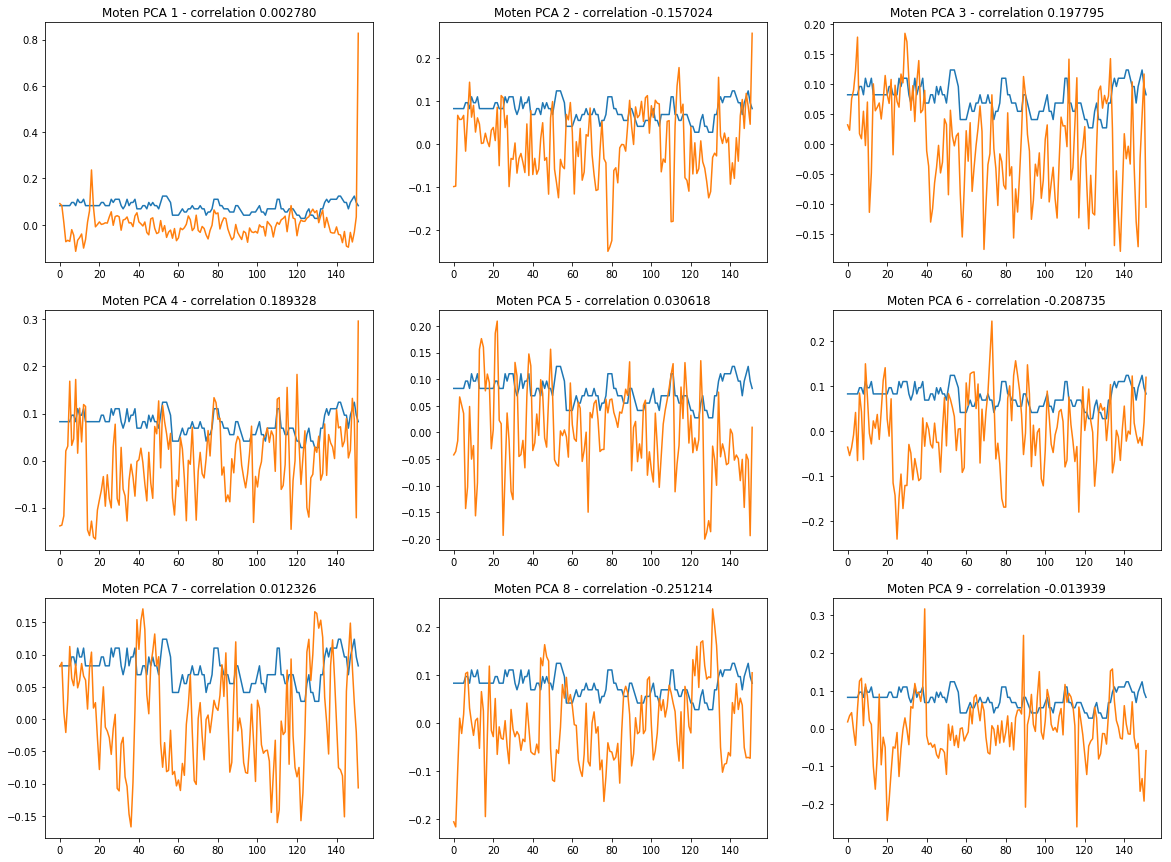

In [158]:
#### Compare moten PCs to social features

# Set social feature to social interaction
social_feature = normalize_pc(social_features[:,3])
print('Comparisons with valence')

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,15))
ax[0][0].plot(social_feature)
ax[0][0].plot(normalize_pc(moten_pca[:,0]))
ax[0][0].title.set_text(
    'Moten PCA 1 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,0]))[0][1])

ax[0][1].plot(social_feature)
ax[0][1].plot(normalize_pc(moten_pca[:,1]))
ax[0][1].title.set_text(
    'Moten PCA 2 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,1]))[0][1])

ax[0][2].plot(social_feature)
ax[0][2].plot(normalize_pc(moten_pca[:,2]))
ax[0][2].title.set_text(
    'Moten PCA 3 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,2]))[0][1])

ax[1][0].plot(social_feature)
ax[1][0].plot(normalize_pc(moten_pca[:,3]))
ax[1][0].title.set_text(
    'Moten PCA 4 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,3]))[0][1])

ax[1][1].plot(social_feature)
ax[1][1].plot(normalize_pc(moten_pca[:,4]))
ax[1][1].title.set_text(
    'Moten PCA 5 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,4]))[0][1])

ax[1][2].plot(social_feature)
ax[1][2].plot(normalize_pc(moten_pca[:,5]))
ax[1][2].title.set_text(
    'Moten PCA 6 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,5]))[0][1])

ax[2][0].plot(social_feature)
ax[2][0].plot(normalize_pc(moten_pca[:,6]))
ax[2][0].title.set_text(
    'Moten PCA 7 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,6]))[0][1])

ax[2][1].plot(social_feature)
ax[2][1].plot(normalize_pc(moten_pca[:,7]))
ax[2][1].title.set_text(
    'Moten PCA 8 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,7]))[0][1])

ax[2][2].plot(social_feature)
ax[2][2].plot(normalize_pc(moten_pca[:,8]))
ax[2][2].title.set_text(
    'Moten PCA 9 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,8]))[0][1])

Comparisons with arousal


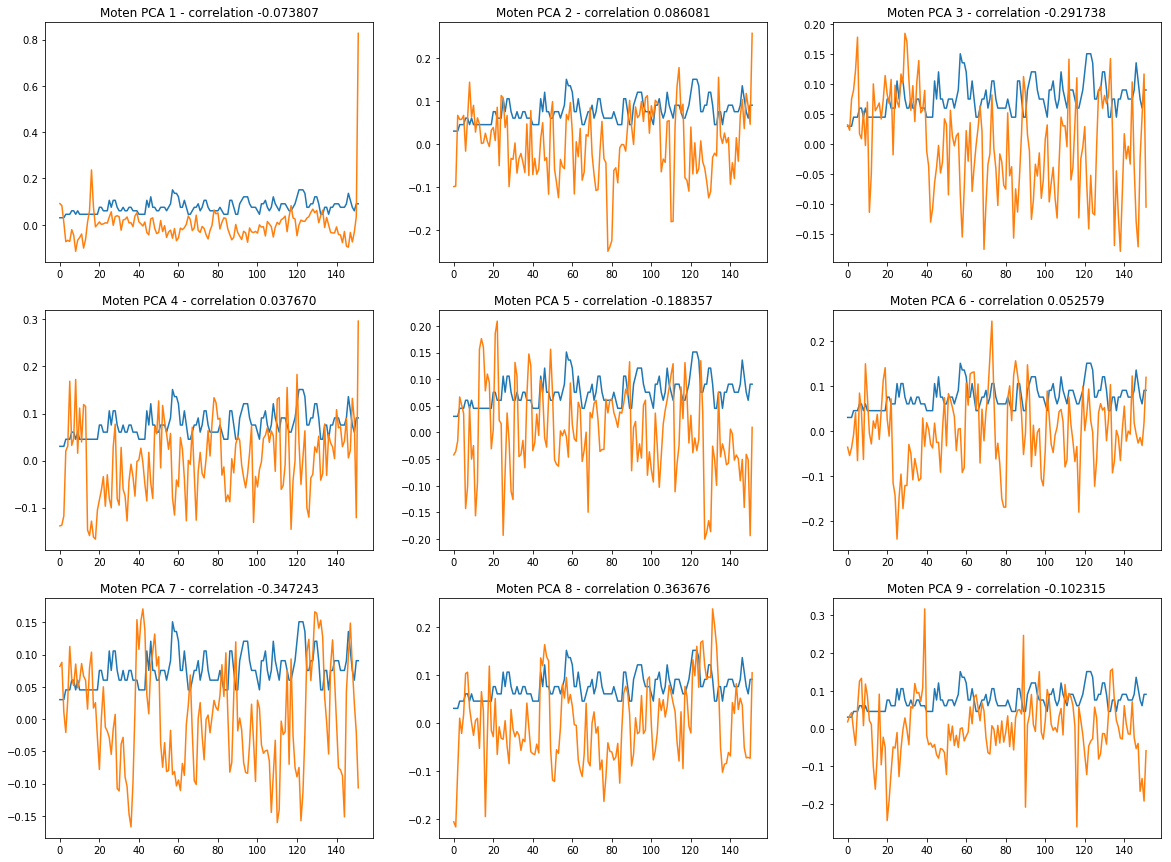

In [159]:
#### Compare moten PCs to social features

# Set social feature to social interaction
social_feature = normalize_pc(social_features[:,4])
print('Comparisons with arousal')

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,15))
ax[0][0].plot(social_feature)
ax[0][0].plot(normalize_pc(moten_pca[:,0]))
ax[0][0].title.set_text(
    'Moten PCA 1 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,0]))[0][1])

ax[0][1].plot(social_feature)
ax[0][1].plot(normalize_pc(moten_pca[:,1]))
ax[0][1].title.set_text(
    'Moten PCA 2 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,1]))[0][1])

ax[0][2].plot(social_feature)
ax[0][2].plot(normalize_pc(moten_pca[:,2]))
ax[0][2].title.set_text(
    'Moten PCA 3 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,2]))[0][1])

ax[1][0].plot(social_feature)
ax[1][0].plot(normalize_pc(moten_pca[:,3]))
ax[1][0].title.set_text(
    'Moten PCA 4 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,3]))[0][1])

ax[1][1].plot(social_feature)
ax[1][1].plot(normalize_pc(moten_pca[:,4]))
ax[1][1].title.set_text(
    'Moten PCA 5 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,4]))[0][1])

ax[1][2].plot(social_feature)
ax[1][2].plot(normalize_pc(moten_pca[:,5]))
ax[1][2].title.set_text(
    'Moten PCA 6 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,5]))[0][1])

ax[2][0].plot(social_feature)
ax[2][0].plot(normalize_pc(moten_pca[:,6]))
ax[2][0].title.set_text(
    'Moten PCA 7 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,6]))[0][1])

ax[2][1].plot(social_feature)
ax[2][1].plot(normalize_pc(moten_pca[:,7]))
ax[2][1].title.set_text(
    'Moten PCA 8 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,7]))[0][1])

ax[2][2].plot(social_feature)
ax[2][2].plot(normalize_pc(moten_pca[:,8]))
ax[2][2].title.set_text(
    'Moten PCA 9 - correlation %03f' % np.corrcoef(social_feature, normalize_pc(moten_pca[:,8]))[0][1])

Comparisons with Moten PC 3


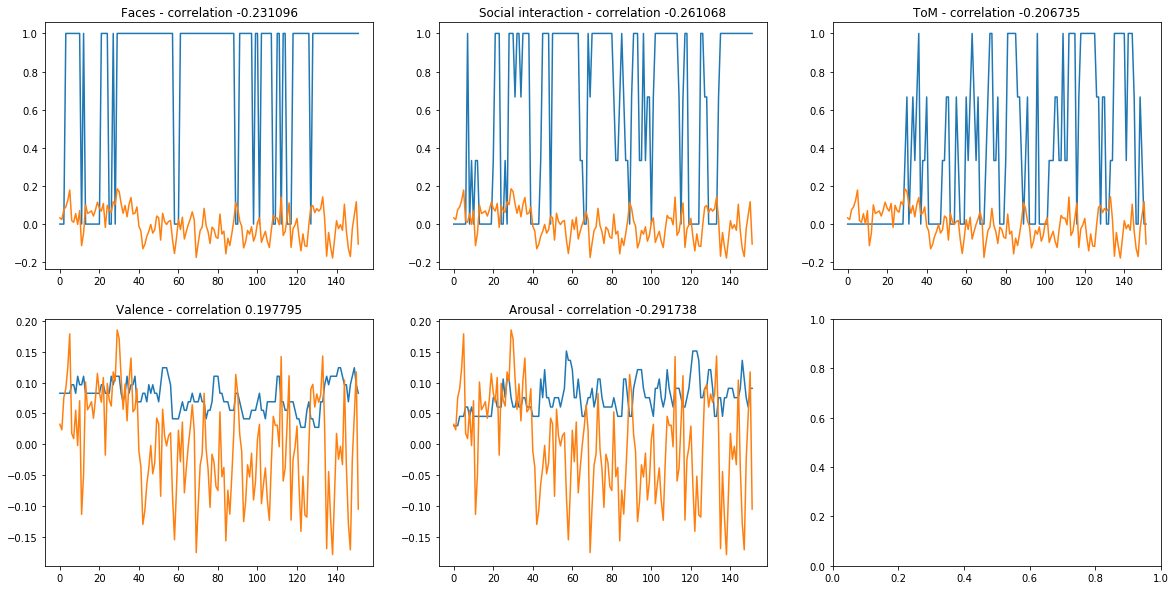

In [165]:
#### Compare moten PCs to social features

# Set social feature to social interaction
social_feature = normalize_pc(social_features[:,4])
moten_feature = normalize_pc(moten_pca[:,2])
print('Comparisons with Moten PC 3')

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
ax[0][0].plot(social_features[:,0])
ax[0][0].plot(moten_feature)
ax[0][0].title.set_text(
    'Faces - correlation %03f' % np.corrcoef(social_features[:,0], moten_feature)[0][1])

ax[0][1].plot(social_features[:,1])
ax[0][1].plot(moten_feature)
ax[0][1].title.set_text(
    'Social interaction - correlation %03f' % np.corrcoef(social_features[:,1], moten_feature)[0][1])

ax[0][2].plot(social_features[:,2])
ax[0][2].plot(moten_feature)
ax[0][2].title.set_text(
    'ToM - correlation %03f' % np.corrcoef(social_features[:,2], moten_feature)[0][1])

ax[1][0].plot(normalize_pc(social_features[:,3]))
ax[1][0].plot(moten_feature)
ax[1][0].title.set_text(
    'Valence - correlation %03f' % np.corrcoef(social_features[:,3], moten_feature)[0][1])

ax[1][1].plot(normalize_pc(social_features[:,4]))
ax[1][1].plot(moten_feature)
ax[1][1].title.set_text(
    'Arousal - correlation %03f' % np.corrcoef(social_features[:,4], moten_feature)[0][1])

Comparisons with Moten PC 4


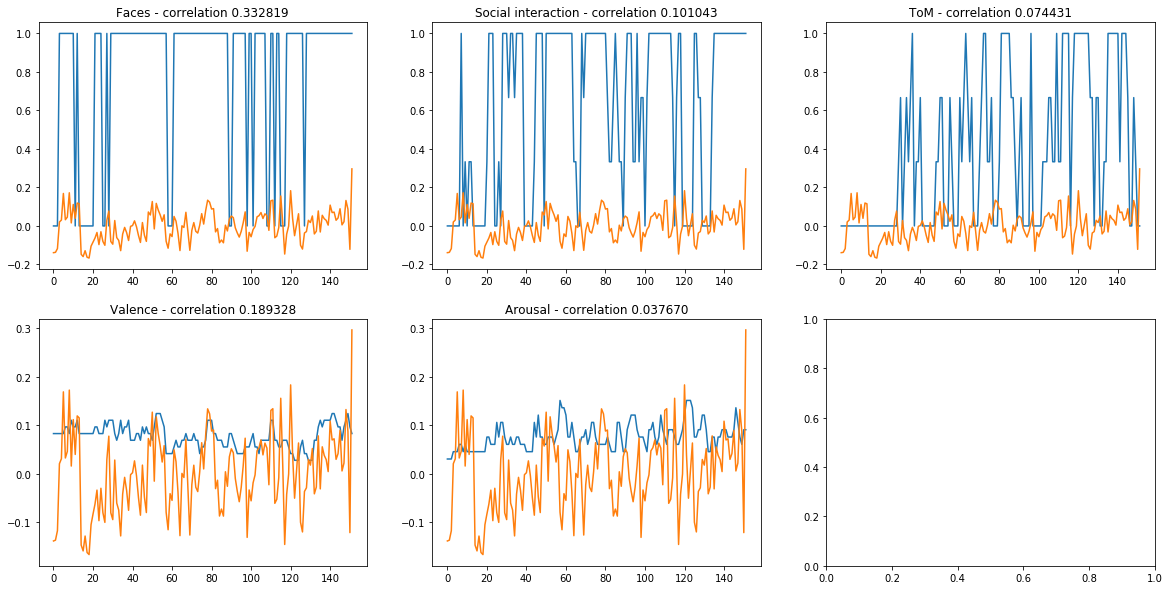

In [163]:
#### Compare moten PCs to social features

# Set social feature to social interaction
social_feature = normalize_pc(social_features[:,4])
moten_feature = normalize_pc(moten_pca[:,3])
print('Comparisons with Moten PC 4')

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
ax[0][0].plot(social_features[:,0])
ax[0][0].plot(moten_feature)
ax[0][0].title.set_text(
    'Faces - correlation %03f' % np.corrcoef(social_features[:,0], moten_feature)[0][1])

ax[0][1].plot(social_features[:,1])
ax[0][1].plot(moten_feature)
ax[0][1].title.set_text(
    'Social interaction - correlation %03f' % np.corrcoef(social_features[:,1], moten_feature)[0][1])

ax[0][2].plot(social_features[:,2])
ax[0][2].plot(moten_feature)
ax[0][2].title.set_text(
    'ToM - correlation %03f' % np.corrcoef(social_features[:,2], moten_feature)[0][1])

ax[1][0].plot(normalize_pc(social_features[:,3]))
ax[1][0].plot(moten_feature)
ax[1][0].title.set_text(
    'Valence - correlation %03f' % np.corrcoef(social_features[:,3], moten_feature)[0][1])

ax[1][1].plot(normalize_pc(social_features[:,4]))
ax[1][1].plot(moten_feature)
ax[1][1].title.set_text(
    'Arousal - correlation %03f' % np.corrcoef(social_features[:,4], moten_feature)[0][1])

Comparisons with Moten PC 7


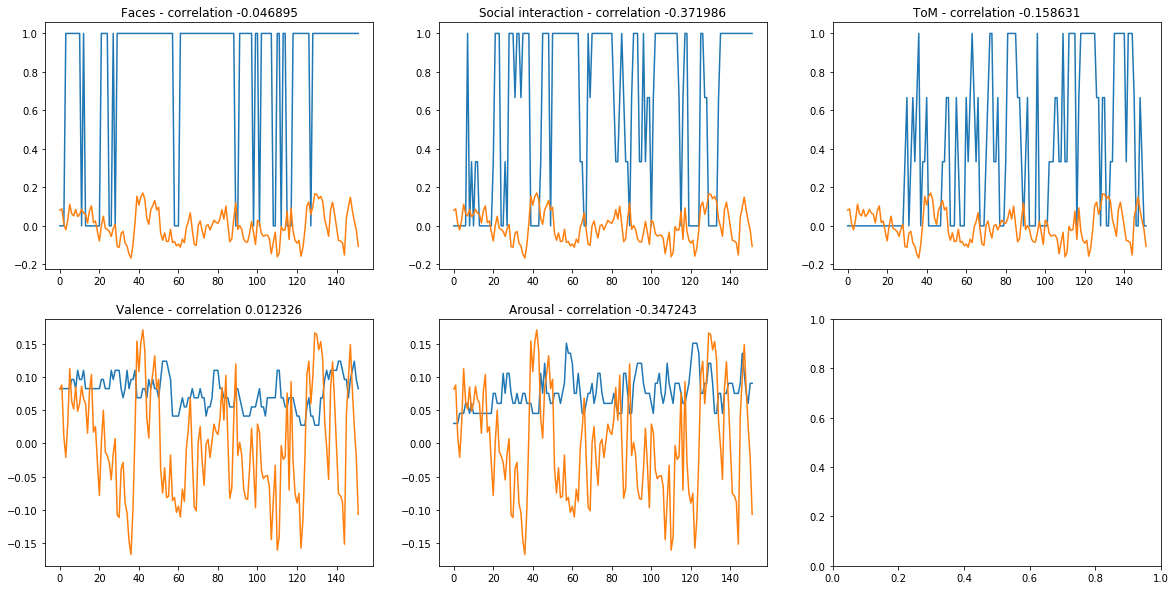

In [164]:
#### Compare moten PCs to social features

# Set social feature to social interaction
social_feature = normalize_pc(social_features[:,4])
moten_feature = normalize_pc(moten_pca[:,6])
print('Comparisons with Moten PC 7')

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
ax[0][0].plot(social_features[:,0])
ax[0][0].plot(moten_feature)
ax[0][0].title.set_text(
    'Faces - correlation %03f' % np.corrcoef(social_features[:,0], moten_feature)[0][1])

ax[0][1].plot(social_features[:,1])
ax[0][1].plot(moten_feature)
ax[0][1].title.set_text(
    'Social interaction - correlation %03f' % np.corrcoef(social_features[:,1], moten_feature)[0][1])

ax[0][2].plot(social_features[:,2])
ax[0][2].plot(moten_feature)
ax[0][2].title.set_text(
    'ToM - correlation %03f' % np.corrcoef(social_features[:,2], moten_feature)[0][1])

ax[1][0].plot(normalize_pc(social_features[:,3]))
ax[1][0].plot(moten_feature)
ax[1][0].title.set_text(
    'Valence - correlation %03f' % np.corrcoef(social_features[:,3], moten_feature)[0][1])

ax[1][1].plot(normalize_pc(social_features[:,4]))
ax[1][1].plot(moten_feature)
ax[1][1].title.set_text(
    'Arousal - correlation %03f' % np.corrcoef(social_features[:,4], moten_feature)[0][1])

<h1>Account for HRF lag in moten and social features</h1>

In [34]:
social_features = np.load(os.path.join(directory, 'features', 'social_normalized.npy'))
print(np.shape(social_features))

moten19_features = np.load(os.path.join(directory, 'features', 'moten_reduced19.npy'))
print(np.shape(moten19_features))

(152, 5)
(152, 19)


In [7]:
social_prepend = social_features[0:2]
print(social_prepend)

[[-2.05946093 -1.45343367 -0.95016228  0.21471859 -1.71569521]
 [-2.05946093 -1.45343367 -0.95016228  0.21471859 -1.71569521]]


In [9]:
social_shifted = np.concatenate((social_prepend,social_features), axis=0)
print(np.shape(social_shifted))

(154, 5)


In [10]:
social_shifted_trimmed = social_shifted[:152]
print(np.shape(social_shifted_trimmed))

(152, 5)


In [25]:
print(social_features[0:10])
print(social_shifted_trimmed[0:10])

[[-2.05946093 -1.45343367 -0.95016228  0.21471859 -1.71569521]
 [-2.05946093 -1.45343367 -0.95016228  0.21471859 -1.71569521]
 [-2.05946093 -1.45343367 -0.95016228  0.21471859 -1.71569521]
 [ 0.48556396 -1.45343367 -0.95016228  0.21471859 -1.1560693 ]
 [ 0.48556396 -1.45343367 -0.95016228  0.21471859 -1.1560693 ]
 [ 0.48556396 -1.45343367 -0.95016228  0.21471859 -1.1560693 ]
 [ 0.48556396 -1.45343367 -0.95016228  0.78730148 -0.5964434 ]
 [ 0.48556396  0.84783631 -0.95016228  0.78730148 -0.5964434 ]
 [ 0.48556396 -1.45343367 -0.95016228  0.21471859 -1.1560693 ]
 [ 0.48556396 -0.68634368 -0.95016228  1.35988438 -0.5964434 ]]
[[-2.05946093 -1.45343367 -0.95016228  0.21471859 -1.71569521]
 [-2.05946093 -1.45343367 -0.95016228  0.21471859 -1.71569521]
 [-2.05946093 -1.45343367 -0.95016228  0.21471859 -1.71569521]
 [-2.05946093 -1.45343367 -0.95016228  0.21471859 -1.71569521]
 [-2.05946093 -1.45343367 -0.95016228  0.21471859 -1.71569521]
 [ 0.48556396 -1.45343367 -0.95016228  0.21471859 -1.1

In [37]:
print(moten19_features[0:2])
moten_prepend = moten19_features[0:2]
print(moten_prepend)

[[ 35.39443965 -16.58797321   4.88118546 -16.64312028  -4.62475707
   -3.80956472   8.43677521 -19.5338169    1.56505913  -1.80853885
    9.21488331  -6.35290927 -13.93590081   0.88219284  -8.7485755
    4.92043162   1.67263167  -5.76273583  -2.33380991]
 [ 32.02412798 -16.41636255   3.53807502 -16.4446072   -3.92449128
   -5.79408957   9.09663094 -20.54017886   3.03046056  -2.72342609
    9.42461329  -6.24414387 -14.15999845   2.07918813  -8.75888917
    4.52398731   1.83451533  -4.52826621  -1.57819907]]
[[ 35.39443965 -16.58797321   4.88118546 -16.64312028  -4.62475707
   -3.80956472   8.43677521 -19.5338169    1.56505913  -1.80853885
    9.21488331  -6.35290927 -13.93590081   0.88219284  -8.7485755
    4.92043162   1.67263167  -5.76273583  -2.33380991]
 [ 32.02412798 -16.41636255   3.53807502 -16.4446072   -3.92449128
   -5.79408957   9.09663094 -20.54017886   3.03046056  -2.72342609
    9.42461329  -6.24414387 -14.15999845   2.07918813  -8.75888917
    4.52398731   1.83451533  -4.

In [38]:
moten_shifted = np.concatenate((moten_prepend, moten19_features), axis=0)
print(np.shape(moten_shifted))

(154, 19)


In [39]:
moten_shifted_trimmed = moten_shifted[:152]
print(np.shape(moten_shifted_trimmed))

(152, 19)


In [41]:
print(moten19_features[0:5])
print('--')
print(moten_shifted_trimmed[0:5])

[[ 35.39443965 -16.58797321   4.88118546 -16.64312028  -4.62475707
   -3.80956472   8.43677521 -19.5338169    1.56505913  -1.80853885
    9.21488331  -6.35290927 -13.93590081   0.88219284  -8.7485755
    4.92043162   1.67263167  -5.76273583  -2.33380991]
 [ 32.02412798 -16.41636255   3.53807502 -16.4446072   -3.92449128
   -5.79408957   9.09663094 -20.54017886   3.03046056  -2.72342609
    9.42461329  -6.24414387 -14.15999845   2.07918813  -8.75888917
    4.52398731   1.83451533  -4.52826621  -1.57819907]
 [  3.904051    11.22338633  11.37676208 -14.09586236  -1.72807314
   -3.92216776   1.13414575  -9.3292429    3.78699481  -9.13243891
    5.93164468  -5.37950879  -9.46479184   1.49085704  -5.20709501
    3.13025869  -1.80982634  -7.14412683   4.07876074]
 [-28.33019917   9.58731284  13.55774923   2.45024787   7.33679994
   -0.91964122  -2.14266999   0.92949733  -0.42056619  -2.09297007
    1.17533393  -8.01695539  -3.87806572   6.83354898  -3.24032269
    4.06018049   1.77613388  -5.

In [42]:
np.save(os.path.join(directory, 'features', 'social_shifted.npy'), social_shifted_trimmed)
np.save(os.path.join(directory, 'features', 'moten19_shifted.npy'), moten_shifted_trimmed)